Fitting 3 folds for each of 18 candidates, totalling 54 fits
[[1515  789]
 [ 722 1588]]
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      2304
           1       0.67      0.69      0.68      2310

    accuracy                           0.67      4614
   macro avg       0.67      0.67      0.67      4614
weighted avg       0.67      0.67      0.67      4614



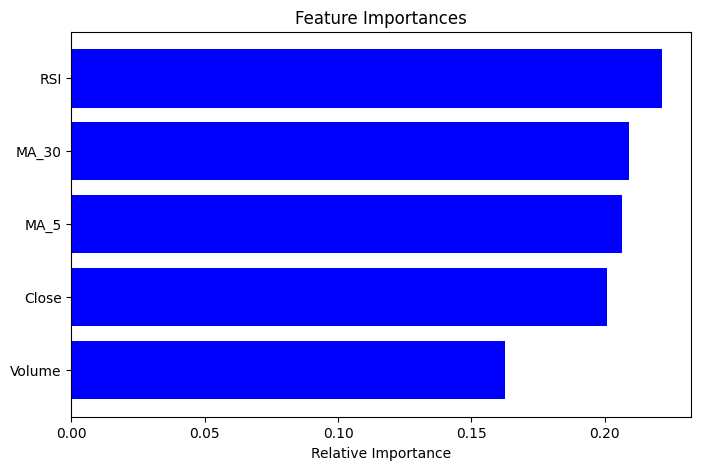

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

# Fetch data
sp500 = yf.Ticker("^GSPC")
data = sp500.history(period="max")

# Preprocess and clean data
data["Tomorrow"] = data["Close"].shift(-1)
data['Target'] = (data["Tomorrow"] > data["Close"]).astype(int)
data.dropna(inplace=True)  # Remove rows with NaN values

# Feature Engineering
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_30'] = data['Close'].rolling(window=30).mean()
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Separate majority and minority classes
majority = data[data['Target'] == 0]
minority = data[data['Target'] == 1]

# Balance classes by oversampling minority
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=123)
data_balanced = pd.concat([majority, minority_upsampled])
data_balanced = data_balanced.sample(frac=1, random_state=123)  # Shuffle

# Split data into training and testing sets
predictors = ['Close', 'Volume', 'MA_5', 'MA_30', 'RSI']
X_train, X_test, y_train, y_test = train_test_split(data_balanced[predictors], data_balanced['Target'], test_size=0.2, random_state=123)

# Model training with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(estimator=rf(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_

# Predictions
predictions = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Feature importance
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)
plt.figure(figsize=(8, 5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [predictors[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
